![charm_logo](https://charmtx.com/wp-content/uploads/2022/05/CHARM_Logo_Colour.png)

Hi Ewan. I've annotated your submitted notebook to the takehome test. Overall we were very impressed with the speed in which you'd picked up RDKit, and everyone spoke very highly of you. Unfortunately, we weren't confident that we have the capacity to give you the training and support you deserve. Both myself and Laksh started graduate schemes directly after our Masters, and I think a similiar program would be a good fit for you. I've looked over your CV and it's very impressive, I wouldn't change anything. I've left a few resources below which have certainly helped me throughout the years.

In terms of your solution. Overall it was good. There are a few convoluted sections. In our ideal solution we hope to see candidates using either SMARTS matching to find the bridging groups and basic nitrogens, or using the atom tags in the PDB file to determine the OD1 and OD2 oxygens. If you use exclusively SMARTS, then they'll need to use the GetPDBResidueInfo info to get the atom_number-to-residue_number mapping. Personally, I prefer the SMARTS-based approach. You can compute all possible salt bridges to any residue, and then perform a simple filter to ASP155 at the end. This has the benefit of being a generic function to find any salt bridge, you just need to add a simple filter function at the end. Some good resources to look at would be https://github.com/chemosim-lab/ProLIF/blob/master/prolif/interactions.py and https://github.com/oddt/oddt/blob/bfbf9ea99768b556684dc99c6ac87a9f16b16f80/oddt/interactions.py#L299. Both of these use the SMARTS approach.

# Some useful resources:

Blogs
- https://www.cambridgemedchemconsulting.com/resources/ - General information about the drug discovery process
- https://practicalcheminformatics.blogspot.com/ - A useful chemoinformatics blog with a few RDKit implementations solving common problems 
- https://iwatobipen.wordpress.com/ - An even more useful blog, with literally 100s of posts trialling out new methods and approaches
- https://www.science.org/blogs/pipeline Derek Lowe's blog with mostly useful, sometimes somewhat inflammatory posts. Definitely worth a read.

Git repos
- https://github.com/InformaticsMatters/virtual-screening A repository of common virtual screening methods
- https://github.com/oddt/oddt/ A toolkit wrapper around RDKit, to help apply RDKit to common tasks in drug discovery

Other:
- https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#EXMPL Examples of how to use SMARTS matching
- https://smarts.plus/smartscreate - Visualise SMARTS patterns
- https://marvinjs-demo.chemaxon.com/latest/ Easy tool to draw molecules and extract the SMARTS pattern

**Import libraries and presets**

In [ ]:
import numpy as np
#COMMENT: This is genuinely very impressive! The speed that you've picked up RDKit is incredible. 

import rdkit #COMMENT This isn't used
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors #COMMENT Nor are these imports
from rdkit.Chem.Draw import IPythonConsole

from scipy.spatial.distance import cdist

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

**File Input**

In [ ]:
#COMMENT: This is a great helper function! You use types and docstrings, and the func is very clear.
def load_pdb(pdb_file: str) -> Chem.Mol:
    '''
    Loads a protein database file as an rdkit.Chem.Mol object.
    
    Inputs:
    -------
    - pdb_file: str
        Filepath for protein database file.
    
    Returns:
    --------
    - pdb: Chem.Mol
        A Chem.Mol representing the protein database file.
    '''
    pdb = Chem.MolFromPDBFile(pdb_file)
    
    residues = {atom.GetPDBResidueInfo().GetResidueNumber() for atom in pdb.GetAtoms()}
    
    #COMMENT: You could use a logger instead of the print function.
    #COMMENT: This means you can set logs at different levels, and only flood your terminal when 
    #COMMENT: something has gone wrong.
    print(f'Loaded PDB file with {len(residues)} residues and {Chem.rdMolDescriptors.CalcNumHeavyAtoms(pdb)} heavy atoms. \n') 
    
    return pdb
    
    
def load_sdf(sdf_file: str) -> list[Chem.Mol]:
    '''
    Loads a SDF file containing possible ligand positions as a list of rdkit.Chem.Mol objects.
    
    Inputs:
    -------
    - sdf_file: str
        Filepath for SDF file.
    
    Returns:
    --------
    - ligands: list[Chem.Mol]
        A list where each element is a different ligand position represented as a Chem.Mol object.
    '''
    suppl = Chem.SDMolSupplier(sdf_file) #COMMENT: The reason molecules fail (and become None objects)
    #COMMENT: is because RDKit fails to sanitize the molecule due to incorrect valency.
    #COMMENT: Depending on your task, you can override this behaviour with 
    #COMMENT: Chem.SDMolSupplier(sdf_file, sanitize=False)
    ligands = [ligand for ligand in suppl if ligand is not None]
    missing = [ligand for ligand in suppl if ligand is None] #COMMENT: This will just yield a list of Nones [None]
    #COMMENT: which doesn't serve a purpose. You could get the full length of the suppl iter with len(iter(suppl))
    #COMMENT: and then subtract len(ligands)
    
    print(f'Loaded SDF file containing {len(suppl)} molecules,')
    print(f'{len(ligands)} read correctly, {len(missing)} read as None. \n')
    
    return ligands

In [ ]:
#COMMENT: Nice articulate logging
pdb = load_pdb("protein_6a93.pdb")
all_ligands = load_sdf("ligands_5ht2a.sdf")

Loaded PDB file with 373 residues and 2932 heavy atoms. 

Loaded SDF file containing 414 molecules,
414 read correctly, 0 read as None. 



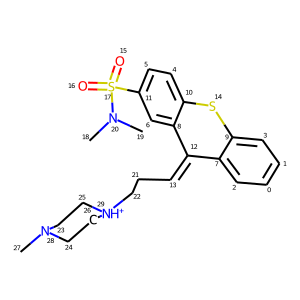

In [ ]:
#COMMENT: Good sanity check
#COMMENT: Later in the notebook, you say you don't know what an SDTag is.
#COMMENT: All of these are SDTags. They're simply additional str tag/value pairs in the SDF file
#COMMENT: (See below)
test_ligand = all_ligands[1]
test_ligand

In [302]:
!head -90 ligands_5ht2a.sdf




 31 34  0  0  0  0  0  0  0  0999 V2000
   12.1356   -0.6977   61.9364 C   0  0  0  0  0  0  0  0  0  0  0  0
   11.3271   -0.5532   60.8143 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.5082   -0.4627   61.8434 C   0  0  0  0  0  0  0  0  0  0  0  0
   11.8908   -0.1833   59.5945 C   0  0  0  0  0  0  0  0  0  0  0  0
   16.2990   -0.3226   56.8152 C   0  0  0  0  0  0  0  0  0  0  0  0
   17.6247   -0.7519   56.8440 C   0  0  0  0  0  0  0  0  0  0  0  0
   17.6184   -0.5925   59.2520 C   0  0  0  0  0  0  0  0  0  0  0  0
   14.0918   -0.0699   60.6259 C   0  0  0  0  0  0  0  0  0  0  0  0
   16.2874   -0.1393   59.2416 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.2705    0.0485   59.4886 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.6205   -0.0258   58.0069 C   0  0  0  0  0  0  0  0  0  0  0  0
   18.2821   -0.8917   58.0612 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.5539    0.1727   60.4977 C   0  0  0  0  0  0  0  0  0  0  0  0
   16.2035    0.8017   61.4965 C   0  0  0  0  

**Finding coordinates of bridge forming Os in ASP**

In [ ]:
#COMMENT: You previously used snake_case and now use CapitalisedCase for ResidueIndex
#COMMENT: Nice edge case caught, you could add an assert to check for this
#COMMENT: assert protein.GetAtomWithIdx(0).GetPDBResidueInfo() != None, "No PDB residue information found."
def GetResidueAtoms(protein: Chem.Mol, ResidueIndex: int) -> list[int]:
    '''
    This function will return a list of all indexes of atoms belonging to a specified residue index in a given protein. The 
    protein must be imported from a PDB file otherwise GetPDBResidueInfo will return None.
    
    It is possible to write this as a list comprehension (as shown) however this function is more readable.
    
    Inputs:
    -------
    - protein: Chem.Mol
        A Chem.Mol representing a PDB file.
    - ResidueIndex: int
        The index of the desired residue in the protein.
    
    Returns:
    --------
    - ResidueAtomsIdxs: list[int]
        The indexes of all atoms in the chosen residue.
    '''
    #COMMENT: It's more pythonic to use snake_case for variable names. CapCase is reserved for classes.
    ResidueAtomsIdxs = []
    
    # lst_comp = [atom.GetIdx() for atom in protein.GetAtoms() if atom.GetPDBResidueInfo().GetResidueNumber() == ResidueIndex]
    
    #COMMENT: This can be written in one line
    #COMMENT:residue_atom_idxs = [atom.GetIdx() for atom in protein.GetAtoms() \
    #COMMENT:                     if atom.GetPDBResidueInfo().GetResidueNumber() == ResidueIndex]
    
    for atom in protein.GetAtoms():
        if atom.GetPDBResidueInfo().GetResidueNumber() == ResidueIndex:
            ResidueAtomsIdxs.append( atom.GetIdx() )
    
    return ResidueAtomsIdxs

#COMMENT: Again different cases are used for variable names.
#COMMENT: ResidueAtomsIdxs isn't used
#COMMENT: Although jupyter notebook and jupyter lab are handy, you can also run notebooks through the VSCode IDE
#COMMENT: The benefit of this is you get all the bells and whilstes of an IDE. For example,
#COMMENT: It immeditately showed me which of your imports and variables weren't been used
def GetBridgingGroup(mol: Chem.Mol, ResidueAtomsIdxs: list[int], BridgingGroupSMILE: str) -> list[int]:
    '''
    This function takes the SMILE string of a bridging group (e.g. COO- in ASP) and returns all indexes of atoms in that
    group from the list given (ResidueAtomsIdxs).
    
    Is there a way to draw an image of just this residue within the atom? You could highlight the BridgingGroupSMILE atoms
    as this would provide a nice and easy sense check of results.
    
    Inputs:
    -------
    - mol: Chem.Mol
        The molecule that indexes in ResidueAtomsIdxs refer to.
    - ResidueAtomsIdxs: list[int]
        The indexes of chosen atoms in mol.
    - BridgingGroupSMILE: str
        The SMILE string for the bridging group for this residue. 
    
    Returns:
    --------
    - BridgingGroupIdxs: list[int]
        The indexes of the bridging group atoms in this residue.
    '''
    #COMMENT: Use snake_case
    BridgingGroupIdxs = []
    
    #COMMENT: The variable is called SMILES, but you're actually searching for a SMARTS string,
    #COMMENT: which is a more powerful regex style language for substructure searching molecules
    BridgingGroup = Chem.MolFromSmarts(BridgingGroupSMILE)
    matches = mol.GetSubstructMatches(BridgingGroup)

    for match in matches:
        if set(match).issubset(set(ResidueAtomIdxs)):
            BridgingGroupIdxs.extend(match)
            
    return BridgingGroupIdxs
       

def FilterElements(mol: Chem.Mol, BridgingGroupIdxs: list[int], elements: set) -> list[int]:
    '''
    This function will return a subset of the ResidueAtomsIdxs list. All elements within the subset are indexes which 
    correspond to chemical elements in the elements set. 
    
    It is possible to write this as a list comprehension (as shown) however this function is more readable.
    
    Inputs:
    -------
    - mol: Chem.Mol
        The molecule that indexes in BridgingGroupIdxs refer to.
    - BridgingGroupIdxs: list[int]
        The indexes of chosen atoms in mol.
    - elements: set(str)
        A set of chemical elements that you wish to filter for e.g. set('N', 'S', 'Fe')
    
    Returns:
    --------
    - ResidueElementIdxs: list[int]
        A filtered subset of ResidueAtomsIdxs containing only atoms of specific element(s).
    '''
    ResidueElementIdxs = []
    
    #COMMENT: lst_comp = [ idx for idx in ResidueAtomsIdx if mol.GetAtomWithIdx(idx).GetSymbol() in element]
    
    for idx in BridgingGroupIdxs:
            if mol.GetAtomWithIdx(idx).GetSymbol() in elements:
                ResidueElementIdxs.append(idx)
    
    return ResidueElementIdxs


def GetPositions(mol: Chem.Mol, ResidueBridgingIdxs: list[int]) -> np.ndarray:
    '''
    This function finds the xyz positions of each atom in mol whos index is given by ResidueBridgingIdxs. 
    
    Inputs:
    -------
    - mol: Chem.Mol
        The molecule that indexes in ResidueBridgingIdxs refer to.
    - ResidueBridgingIdxs: list[int]
        The indexes of chosen atoms in mol.
    
    Returns:
    --------
    -coords: np.ndarray((n,3)) s.t. n = len(ResidueBridgingIdxs)
        The xyz position of each atom given in ResidueBridgingIdxs.
    '''
    coords = []
    #COMMENT: It would be more efficient to get the numpy array of Nx3 coordinate matrix once, and
    #COMMENT: then index the appropriate rows using ResidueBridgingIdxs
    
    #COMMENT: coords = mol.GetConformer().GetPositions()
    #COMMENT: residue_bridging_idxs = np.array(residue_bridging_idxs)
    #COMMENT: coords[residue_bridging_idxs]

    for idx in ResidueBridgingIdxs:
    
        coord = [mol.GetConformer().GetAtomPosition(idx).x, 
                 mol.GetConformer().GetAtomPosition(idx).y, 
                 mol.GetConformer().GetAtomPosition(idx).z]

        coords.append((coord))
    
    return np.array(coords)


def positions_from_protein(protein: Chem.Mol, ResidueIndex: int, elements: set) -> np.ndarray:
    '''
    This function gives the xyz coordinates of possible salt-bridging atoms in a specific protein residue. As long as these
    atoms are in beta positions to one another e.g. a carboxylate group (COO-).
    
    Inputs:
    -------
    - protein: Chem.Mol
        A Chem.Mol representing a PDB file.
    - ResidueIndex: int
        The index of the desired residue in the protein.
    - elements: set(str)
        A set of chemical elements that you wish to filter for e.g. set('N', 'S', 'Fe')
        
    Returns:
    --------
    - _: np.ndarray((2,3))
        The xyz positions of salt-bridge forming carboxylate oxygen atoms (COO-) within a specific residue of a protein.
    '''
    #COMMENT: This is very hard to read. No variable should be called _ unless it's never used again.
    #COMMENT: Rather than filtering for the bridging group using smiles,
    #COMMENT: and then filtering for the oxygens, you could either use SMARTS to
    #COMMENT: find the group, or use the atom tags in the PDB file (labelled as OD1 and OD2)
    #COMMENT: In the example notebook I've sent, they use the atom tags.
    #COMMENT: At the bottom of this notebook, I've included SMARTS queries showing how to find 
    #COMMENT: the acidic and basic groups in the ligand and protein.
    _ = GetResidueAtoms(protein, ResidueIndex)
    _ = GetBridgingGroup(protein, _, 'C(=O)O') 
    _ = FilterElements(protein, _, elements)
    _ = GetPositions(protein, _) 

    
    return _   

In [ ]:
#COMMENT: Great to see some sanity checks

# Testing 

ResidueAtomIdxs = GetResidueAtoms(pdb, 155)
print(ResidueAtomIdxs)

BridgingGroupIdx = GetBridgingGroup(pdb, ResidueAtomIdxs, 'C(=O)O')
print(BridgingGroupIdx)       

filtered = FilterElements(pdb, BridgingGroupIdx, set('O'))
print(filtered)

O_positions = GetPositions(pdb, filtered)
print(O_positions)

ans = positions_from_protein(pdb, 155, set('O'))
print(ans)

[678, 679, 680, 681, 682, 683, 684, 685]
[683, 684, 685]
[684, 685]
[[16.103  3.516 61.899]
 [13.944  3.118 61.906]]
[[16.103  3.516 61.899]
 [13.944  3.118 61.906]]


**Excluding aromatic and aromatic adjacent atoms**

In [ ]:
#COMMENT: Whilst we specified to disclude conjugated atoms, some indeed can form salt bridges.
#COMMENT: This is a bit of a trick, but some groups (amidine and guanidine) can be conjugated and still from bridges
#COMMENT: This function is not needed if you use SMARTS.
#COMMENT: '[NX3,NX4;!$(N*=*);!$(Na)]' detects basic nitrogens and avoids conjugated nitrogens and those adjacent to aromatic systems
#COMMENT: This is still quite a simple definition. See the bottom of the notebook for a more comprehensive definition of a basic group. 
def discluded(ligand: Chem.Mol) -> set:
    '''
    This function finds indexes of all aromatic and aromatic adjactent atoms within a ligand. This is because aromatic and 
    aromatic adjacent atoms cannot form salt-bridges.
    
    In fact it is all conjugated atoms that cannot form salt-bridges as they contain too much electron density. However I
    am not sure how you would include any additional conjugated atoms in a general algorithm without over complicating it.
    
    Additionally this relies on rdkit's definition of aromatic (4n+2) rule. Worht checking that this is consistent with what
    you want.
    
    Inputs:
    -------
    - ligand: Chem.Mol
        The molecule that indexes in ResidueBridgingIdxs refer to.
    
    Returns:
    --------
    - discluded: set(int)
         set containing the indexes of all atoms in the ligand that are aromatic or aromatic adjacent.
    '''
    discluded = set()
    
    for i in range(Chem.rdMolDescriptors.CalcNumHeavyAtoms(ligand)):
        atom = ligand.GetAtomWithIdx(i)
        if atom.GetIsAromatic():
            discluded.add(i)
            
            neighbour = atom.GetNeighbors()
            neighbour = {neighbour[i].GetIdx() for i in range(len(neighbour))}
            discluded.update(neighbour)
            
    return discluded 

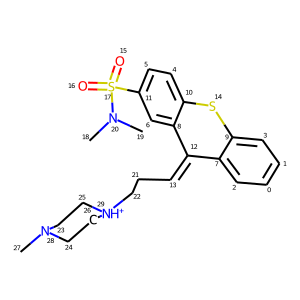

In [ ]:
test_ligand

In [ ]:
NN = discluded(test_ligand)
NN

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17}

**Distance Calculations**

In [ ]:
#COMMENT: This doesn't need to be a function, as it's just a oneliner
def DistanceBetweenAtoms(protein_coords: np.ndarray, ligand_coords: np.ndarray) -> np.ndarray:
    '''
    Given an np.ndarray representing n atomic positions and another representing m, compute the distance between each 
    pair of positions between the two arrays. Will return an array of (n,m) shape. Uses SciPy library.

    Inputs:
    -------
    - protein_coords: np.ndarray((n,3))
        Coordinates of possible salt-bridge forming atoms in the protein.
    - ligand_coords: np.ndarray((m,3))
        Coordinates of possible salt-bridge forming atoms in the ligand.
    
    Returns:
    --------
    - distances: np.ndarray((n,m))
        The distances between each pair of positions between the two arrays.
    '''
    distances = cdist(protein_coords, ligand_coords, 'euclidean')
    
    return distances

#COMMENT: Most software companies will follow the PEP8 style guide
#COMMENT: https://peps.python.org/pep-0008/
#COMMENT: Function names should be camel_case
#COMMENT: The easiest way (imo) to learn PEP8 styling is to use the flake package (pip install flake)
#COMMENT: Running flake my_script.py will convert the script to PEP8 formatting
#COMMENT: You can also install the notebook extension pip install flake[notebook], to reformat notebooks aswell
def MaxMinBelowCutoff(distance_matrix: np.ndarray, cutoff_length: float) -> tuple:
    '''
    This function determines whether any of the potential salt-bridge distances that have been calcualted are beneath the 
    cutoff length. If one or more distance is below the cutoff then the maximum and minimum possible distances are returned,
    otherwise None is returned.
    
    Inputs:
    -------
    - distance_matrix: np.ndarray
        Array containing all of the possible salt-bridge distances.
    - cutoff_length: float
        The maximum possible length of a salt-bridge in Angstroms. 
    
    Returns:
    --------
    - max_min: tuple(float)
        If there is a suitable distance(s) then it is returned as a tuple of the maximum and minimum possible salt-bridge 
        length in Angstroms.
    - None:
        If all of the distances are above the cutoff the None is returned
    '''
    dist = distance_matrix.flatten()
    #COMMENT: np.sort(dist)[::-1] is more pythonic
    dist_sorted = -np.sort(-dist) # sorts in decsending order
    
    if dist_sorted.min() > cutoff_length:
        return None
    
    for i in range(len(dist_sorted)):
        if dist_sorted[i] <= cutoff_length:
            max_min = (dist_sorted[i], dist_sorted.min())
            return max_min

    raise ValueError(f'DistanceBelowThreshold is causing an error for threshold length {threshold_length} and distances {dist_sorted}.')

In [ ]:
## Testing ##
pos_a = np.array([[0,0,0], [1,1,1]])
pos_b = np.array([[1,0,0], [1,1,1]])

dist = DistanceBetweenAtoms(pos_a, pos_b)
print(dist)

bond_len = MaxMinBelowCutoff(dist, 1.5)
print(bond_len)

[[1.         1.73205081]
 [1.41421356 0.        ]]
(1.4142135623730951, 0.0)


**File Output**

In [ ]:
# Faultless function. 
def write_sdf(ligand_list: list[Chem.Mol], filepath: str):
    '''
    Write a list of Chem.Mol objects to an SDF file.
    
    Inputs:
    -------
    - ligand_list: list[Chem.Mol]
        A list of Chem.Mol objects to be written to the SDF file.
    - filepath: str
        Filepath for the newly created SDF file.
        
    Returns:
    --------
    None
    '''
    with Chem.SDWriter(filepath) as output:
        for ligand in ligand_list:
            output.write(ligand)
            # output.write(ligand.GetProp('salt_bridge_distance'))
    
    print(f'Saved output as {filepath} with {len(ligand_list)} molecules. \n')

**Final Function: Filter Molecules**

In [ ]:
def filter_mols(
    pdb_file: str, 
    input_ligand_sdf: str, 
    output_file_sdf: str, 
    asp_index: int,  #COMMENT: This isn't used
    salt_bridge_distance_cutoff: float = 3.5
):
    '''
    Function to filter input ligands to only those poses that contain a salt bridge with 
    the conserved aspartate in the GPCR. Saves the filtered ligands to an SDF file.
    
    Inputs:
    -------
    - pdb_file: str
        The PDB file of the protein to analyse.
            
    - input_ligand_sdf: str
        The sdf file of the docked ligand poses to filter.
            
    - output_file: str
        The sdf file to write the filtered ligands to.
            
    - asp_index: int
        The residue index representing the conserved Aspartate. It is 155 for 5HT2A.
            
    - salt_bridge_distance_cutoff: float
        Docked poses will be kept only if they have a salt bridge less than this specified value in Angstroms.
            
    Returns:
    --------
    None
    '''
    
    #COMMENT:  Very nice comments, and easy to read
    
    # import files
    protein = load_pdb(pdb_file)
    all_ligands = load_sdf(input_ligand_sdf)
    
    # calcualte positions of Os in carboxylate on ASP
    O_positions = positions_from_protein(protein, 155, set('O'))
    
    print('Filtering ligands... \n')

    # loop through ligands to determine if each can for a bridge
    ligands_below_cutoff = []
    for ligand in all_ligands:
        
        # create set of possible bridge forming nitrogens and find their positions
        #COMMENT: list(range(ligand.GetNumAtoms()))
        lst = [i for i in range( len(ligand.GetAtoms()) )]
        all_Ns = FilterElements(ligand, lst, set('N'))
        discluded_Ns = discluded(ligand)
        Ns = set(all_Ns) - discluded_Ns
        
        if len(Ns) == 0:
            continue
            
        N_positions = GetPositions(ligand, list(Ns))
        
        # calculate distances between ends of the bridge (Ns and Os)
        distance_matrix = DistanceBetweenAtoms(O_positions, N_positions)
        max_min_length = MaxMinBelowCutoff(distance_matrix, salt_bridge_distance_cutoff)
        
        # append ligand if it forms a salt bridge below cutoff      
        if max_min_length is not None:
            #COMMENT: It would be best to just yield one distance, not both as a string
            ligand.SetProp('salt_bridge_distance', str(max_min_length))
            ligands_below_cutoff.append(ligand)

    # output ligands that can form a salt-bridge shorter than the cutoff
    write_sdf(ligands_below_cutoff, output_file_sdf)


In [ ]:
## Testing ##
filter_mols("protein_6a93.pdb", "ligands_5ht2a.sdf", "output.sdf", 155)

Loaded PDB file with 373 residues and 2932 heavy atoms. 

Loaded SDF file containing 414 molecules,
414 read correctly, 0 read as None. 

Filtering ligands... 

Saved output as output.sdf with 176 molecules. 



In [ ]:
'''
I have endevoured to make this script as general as possible so that it should be applicable to any protein, residue and 
ligand. As long as you know which group(s) on the residue form a salt bridge. ALthough I cannot be certain without a 
different data set to test it on.

I'm not sure what an SDTag is so I've added the bond length as a property of each ligand.
'''

## Improvements ##

'''
- develop unit testing 
- tracking indexes of which pairs of atoms form which bond lengths
- draw the chosen residue (as a subset of the protein given) with the brid
- 171/176 only have one possilbe bridge, i.e. for the rest max=min in SetProp
- account for all conjugated N, not just those that are aromatic and aromatic adjacent. Could try adding any atom that had a
  double bond attached to it to the set? However this seems overly complex.
'''

'\n- tracking indexes of which pairs of atoms form which bond lengths\n- 171/176 only have one possilbe bridge, i.e. for the rest max=min in SetProp\n- use ligand indexes to identify which atoms form the bridge.\n- write a more general GetBridgingOs function. This works for ASP but would not generalise to other residues.\n- account for all conjugated N, not just those that are aromatic and aromatic adjacent? Could try adding any atom that had a\n  double bond attached to it to the set? However this seems overly complex.\n- generalise to any amino acid residue. This would require a more general GetBridgingOs function and an input of what groups\n  within the residue could form a salt bridge. Maybe do this with SMARTS\n'

[3 4]
[7 8]


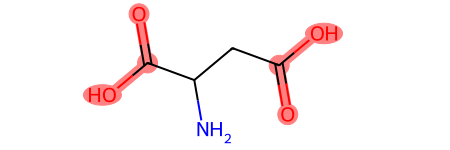

In [287]:
from rdkit import Chem
asp = Chem.MolFromSmiles('C(C(C(=O)O)N)C(=O)O')
not_carbon = np.array([i for i, a in enumerate(asp.GetAtoms()) if a.GetSymbol()!="C"])
acidic_patt = Chem.MolFromSmarts('[CX3](=O)[OX1H0-,OX2H1]')
asp.GetSubstructMatches(patt)
for match in asp.GetSubstructMatches(patt):
    print(np.intersect1d(not_carbon, match))
asp

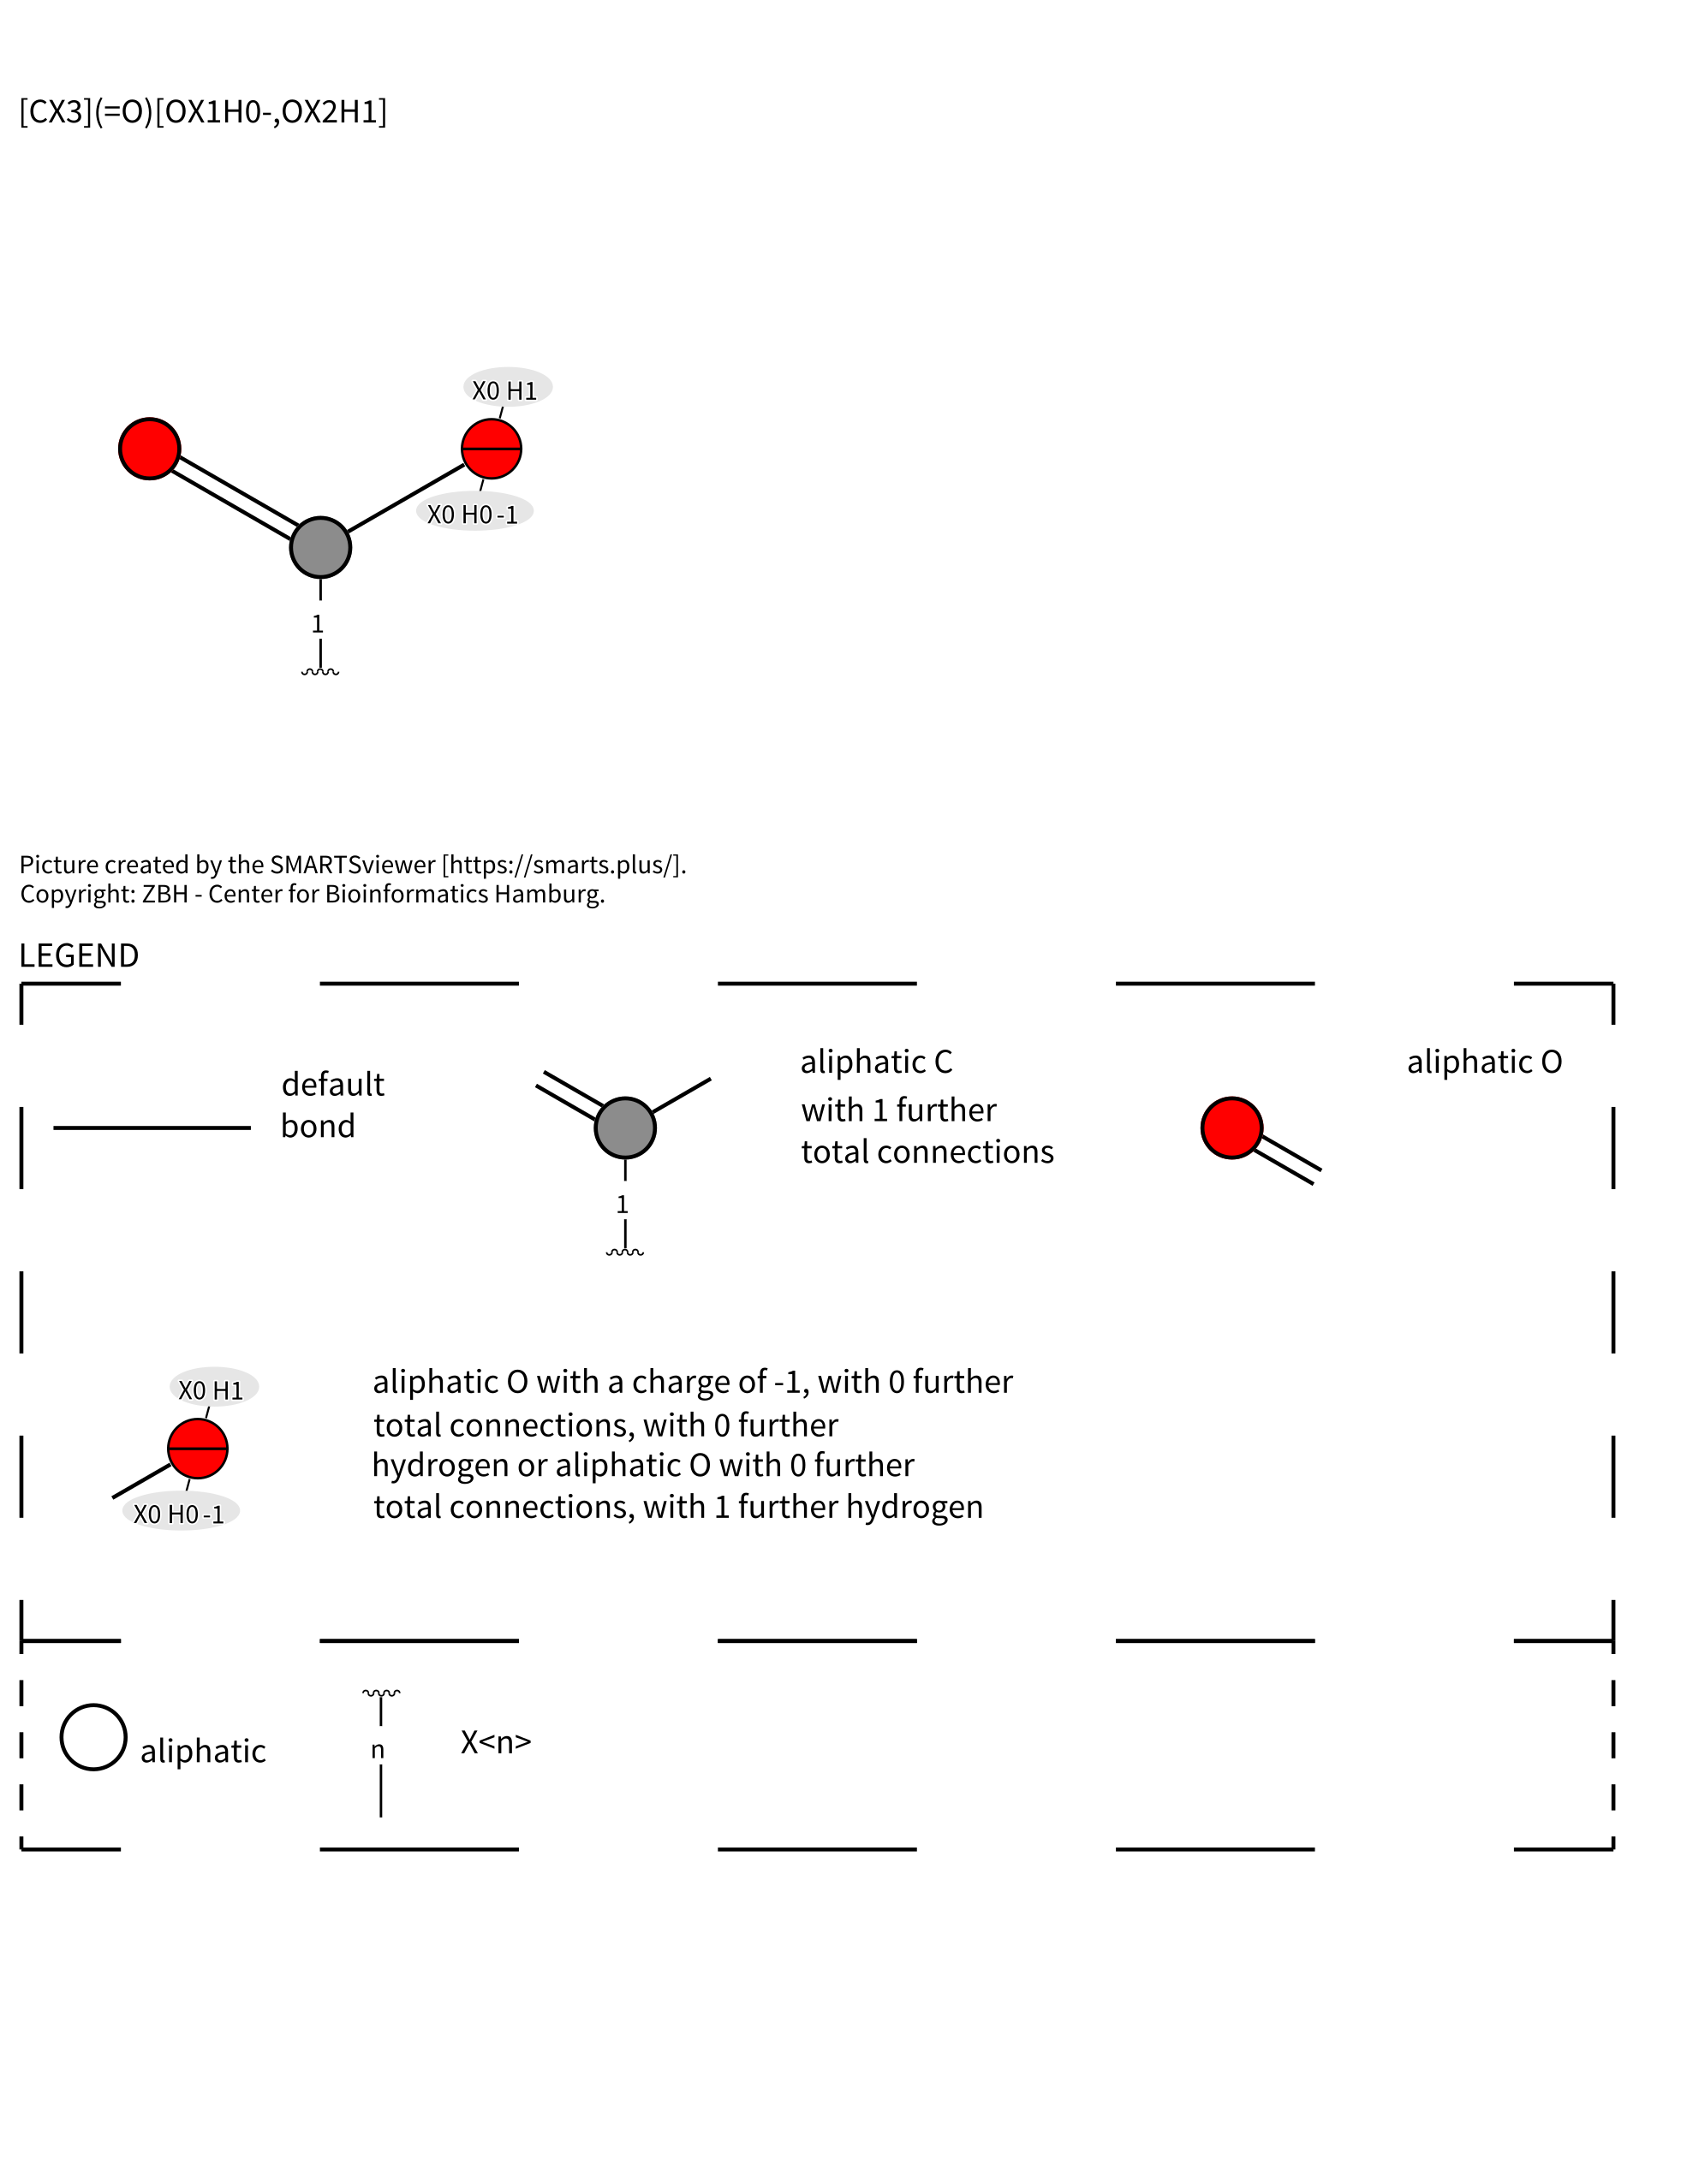

In [288]:
basic_patt = Chem.MolFromSmarts('[$([N;H2&+0][$([C,a]);!$([C,a](=O))]),'
                                  '$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),'
                                  '$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]),'
                                  '$([N,n;X2;+0])]')


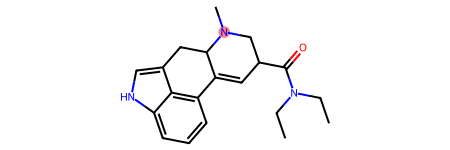

In [289]:
mol = Chem.MolFromSmiles("CCN(CC)C(=O)C1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C")
mol.GetSubstructMatches(basic_patt)
mol

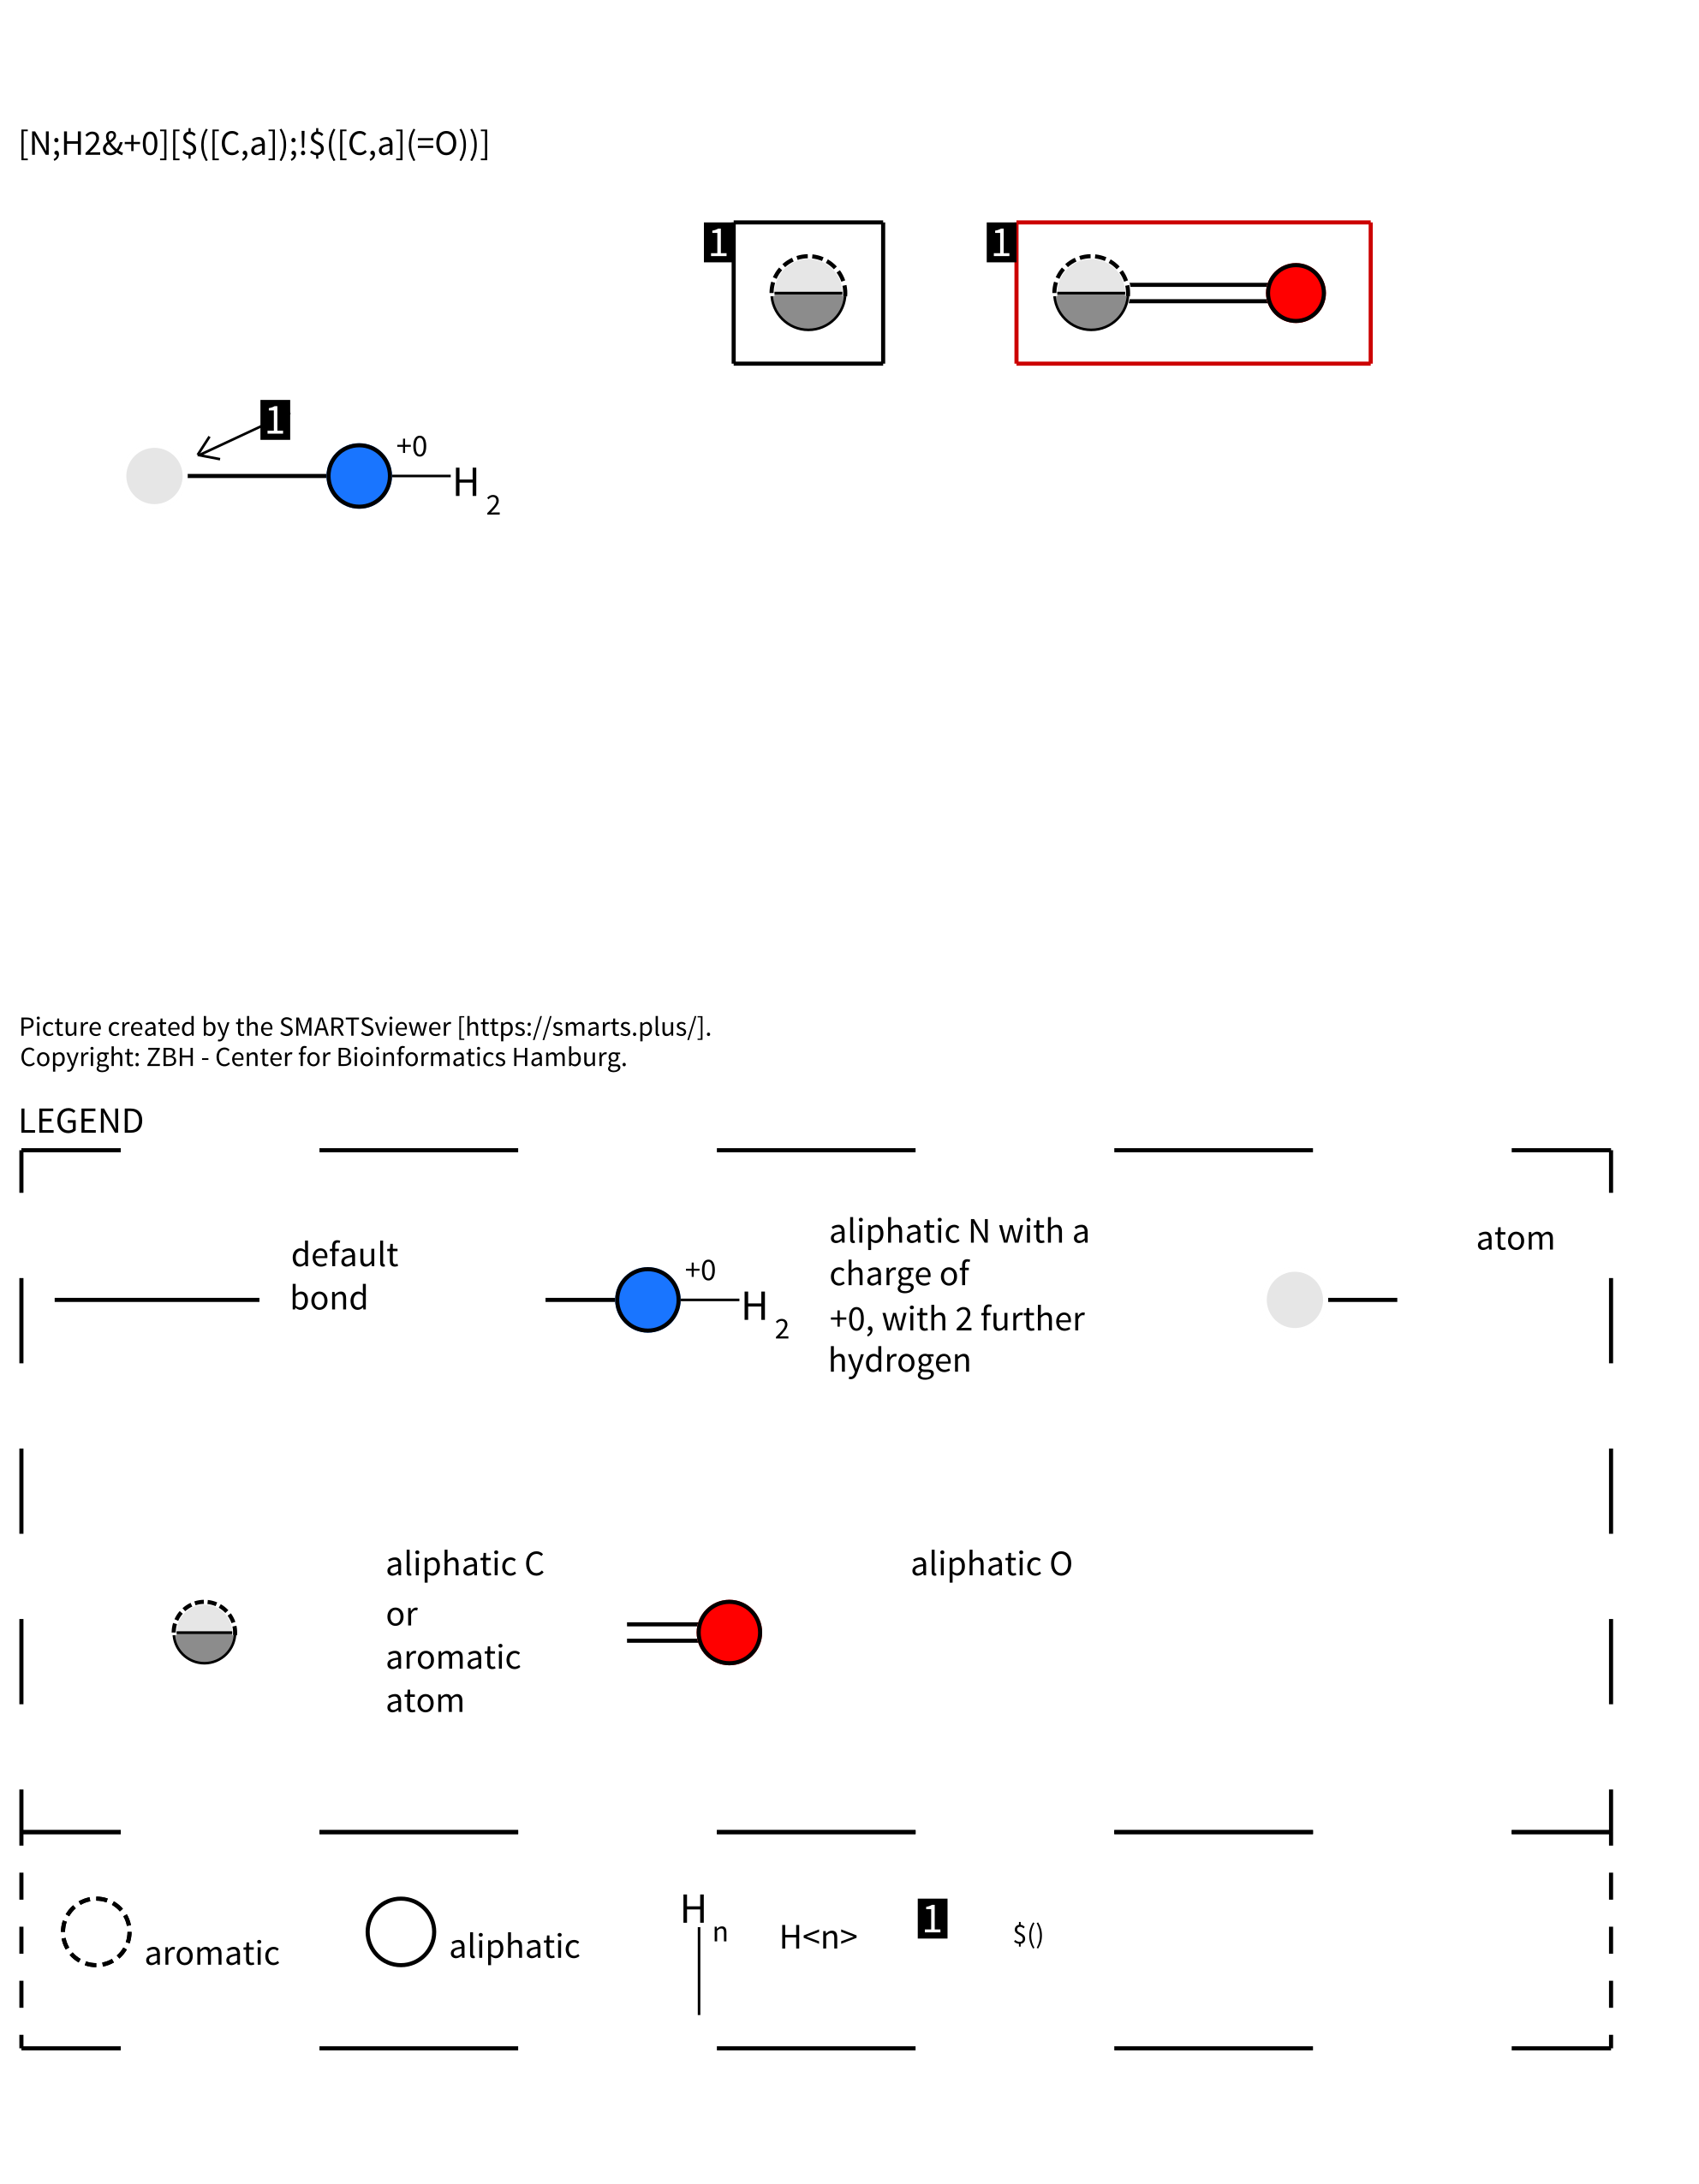

In [297]:
import pandas as pd
from rdkit import Chem
import numpy as np
from numpy.typing import NDArray


def is_asp_oxygens(atom_name: str):
    """Checks if an atom is an aspartate oxygen (excluding terminal oxygens at the C-terminus)"""
    return atom_name.strip() in ("OD1", "OD2")


def get_asp_OD1_OD2_coords(protein: Chem.Mol, asp_index: int) -> NDArray[np.float32]:
    """Returns coordinates of OD1 and OD2 in an Aspartate residue (you define the index)"""
    protein_posns = protein.GetConformer().GetPositions()

    idxs = []
    for atom in protein.GetAtoms():
        if not atom.GetAtomicNum() == 1:
            info = atom.GetPDBResidueInfo()
            if (info.GetResidueNumber() == asp_index) & is_asp_oxygens(info.GetName()):
                idxs.append(atom.GetIdx())

    key_asp_oxygen_coords = protein_posns[idxs]
    return key_asp_oxygen_coords


def build_smarts_pattern(smarts: str):
    return Chem.MolFromSmarts(smarts)

def build_basic_nitrogen_smarts_pattern():
    """
    Build SMARTS pattern that detects basic nitrogens. Specifically, it avoids:
    1. Conjugated nitrogens
    2. Nitrogens adjacent to aromatic systems
    
    It also includes protonated basic nitrogens as well.
    """
    smarts = '[NX3,NX4;!$(N*=*);!$(Na)]'
    return build_smarts_pattern(smarts)


def get_substructure_atom_indices(mol: Chem.Mol, patt: Chem.Mol) -> list[int]:
    """
    Returns the atom indices of a substructure hit from a molecule and SMARTS patter
    """
    hit_ats = list(mol.GetSubstructMatches(patt))
    atom_indices = [grp[0] for grp in hit_ats]
    return atom_indices


def compute_salt_bridge_distance(basic_N_positions: NDArray[np.float32],
                                 asp_OD1_OD2_coords: NDArray[np.float32]) -> np.float32:
    """
    Computes the salt bridge distance. 
    
    Inputs:
        basic_N_positions: numpy.ndarray
            Array with shape (num_basic_nitrogens, 3) 

        asp_OD1_OD2_coords: numpy.ndarray 
            Array with shape (2, 3) representing the coordinates of OD1 and OD2 on the aspartate
        
    Returns:
        salt_bridge_distance: float
            The distance of the salt bridge
    """
    distogram = ((basic_N_positions[:, None] - asp_OD1_OD2_coords[None, :]) ** 2).sum(-1) ** 0.5
    dist_to_either_OD1_or_OD2 = distogram.min(-1)  # Take distance to nearest O out of the two Os in the aspartate
    salt_bridge_distance = dist_to_either_OD1_or_OD2.min()
    return salt_bridge_distance


def filter_mols(
    pdb_file: str, 
    input_ligand_sdf: str, 
    output_file: str, 
    asp_index: int, 
    salt_bridge_distance_cutoff: float = 3.5
):
    """
    Function to filter input ligands to only those poses that contain a salt bridge with 
    the conserved aspartate in the GPCR.
    
    Inputs:
        pdb_file: str
            The PDB file of the protein to analyse.
            
        input_ligand_sdf: str
            The sdf file of the docked ligand poses to filter.
            
        output_file: str
            The sdf file to write the filtered ligands to.
            
        asp_index: int
            The residue index representing the conserved Aspartate. It is 155 for 5HT2A.
            
        salt_bridge_distance_cutoff: float
            Docked poses will be kept only if they have a salt bridge less than this specified value.
            
    Returns:
        None
    """
    # Get conserved aspartate OD1 and OD2 coordinates
    protein = Chem.MolFromPDBFile(pdb_file)
    asp_OD1_OD2_coords = get_asp_OD1_OD2_coords(protein, asp_index=asp_index)
    
    # Build SMARTS pattern to detect basic nitrogen
    basic_nitrogen_patt = build_basic_nitrogen_smarts_pattern()

    writer = Chem.SDWriter(output_file)

    for mol in Chem.SDMolSupplier(input_ligand_sdf):
        if mol is not None:
            # Ignore mols that failed to dock
            
            basic_N_idxs = get_substructure_atom_indices(mol, basic_nitrogen_patt)
            if basic_N_idxs:
                # Only continue if detected basic nitrogen
                basic_N_posns = mol.GetConformer().GetPositions()[basic_N_idxs]
                
                # Compute distance of salt bridge
                salt_bridge_distance = compute_salt_bridge_distance(basic_N_posns, asp_OD1_OD2_coords=asp_OD1_OD2_coords)
                
                # Only write mol if salt bridge < 3.5A is formed
                if salt_bridge_distance < salt_bridge_distance_cutoff:
                    writer.write(mol)
    
    writer.close()


filter_mols(
    pdb_file="protein_6a93.pdb",
    input_ligand_sdf="ligands_5ht2a.sdf", 
    output_file="filtered_poses.sdf",
    asp_index=155,
    salt_bridge_distance_cutoff=3.5,
)